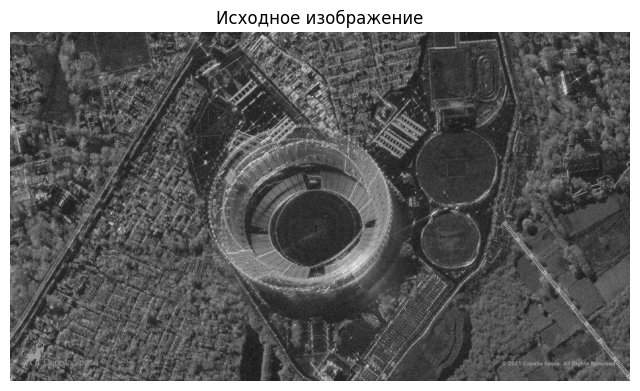

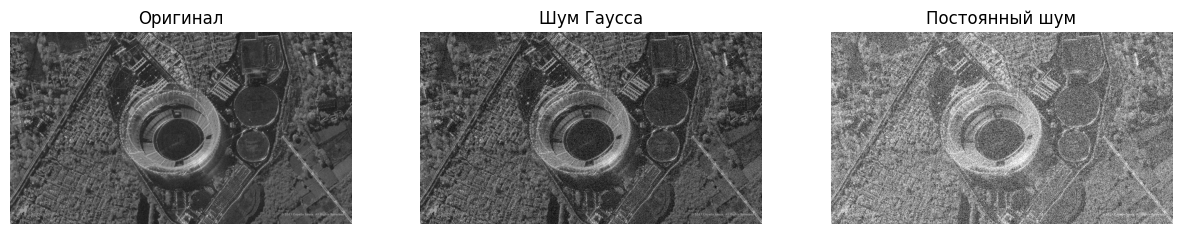

Метрики фильтров:
             Filter     Noise       MSE      SSIM
0        Median 3x3  Gaussian  0.003305  0.632077
1        Median 5x5  Gaussian  0.003718  0.558791
2      Gaussian 3x3  Gaussian  0.002382  0.710333
3      Gaussian 5x5  Gaussian  0.003729  0.553732
4         Bilateral  Gaussian  0.007487  0.506118
5   Non-Local Means  Gaussian  0.003679  0.537801
6        Median 3x3  Constant  0.055557  0.350822
7        Median 5x5  Constant  0.052157  0.376381
8      Gaussian 3x3  Constant  0.050675  0.458150
9      Gaussian 5x5  Constant  0.050046  0.430925
10        Bilateral  Constant  0.084851  0.178142
11  Non-Local Means  Constant  0.074899  0.208041


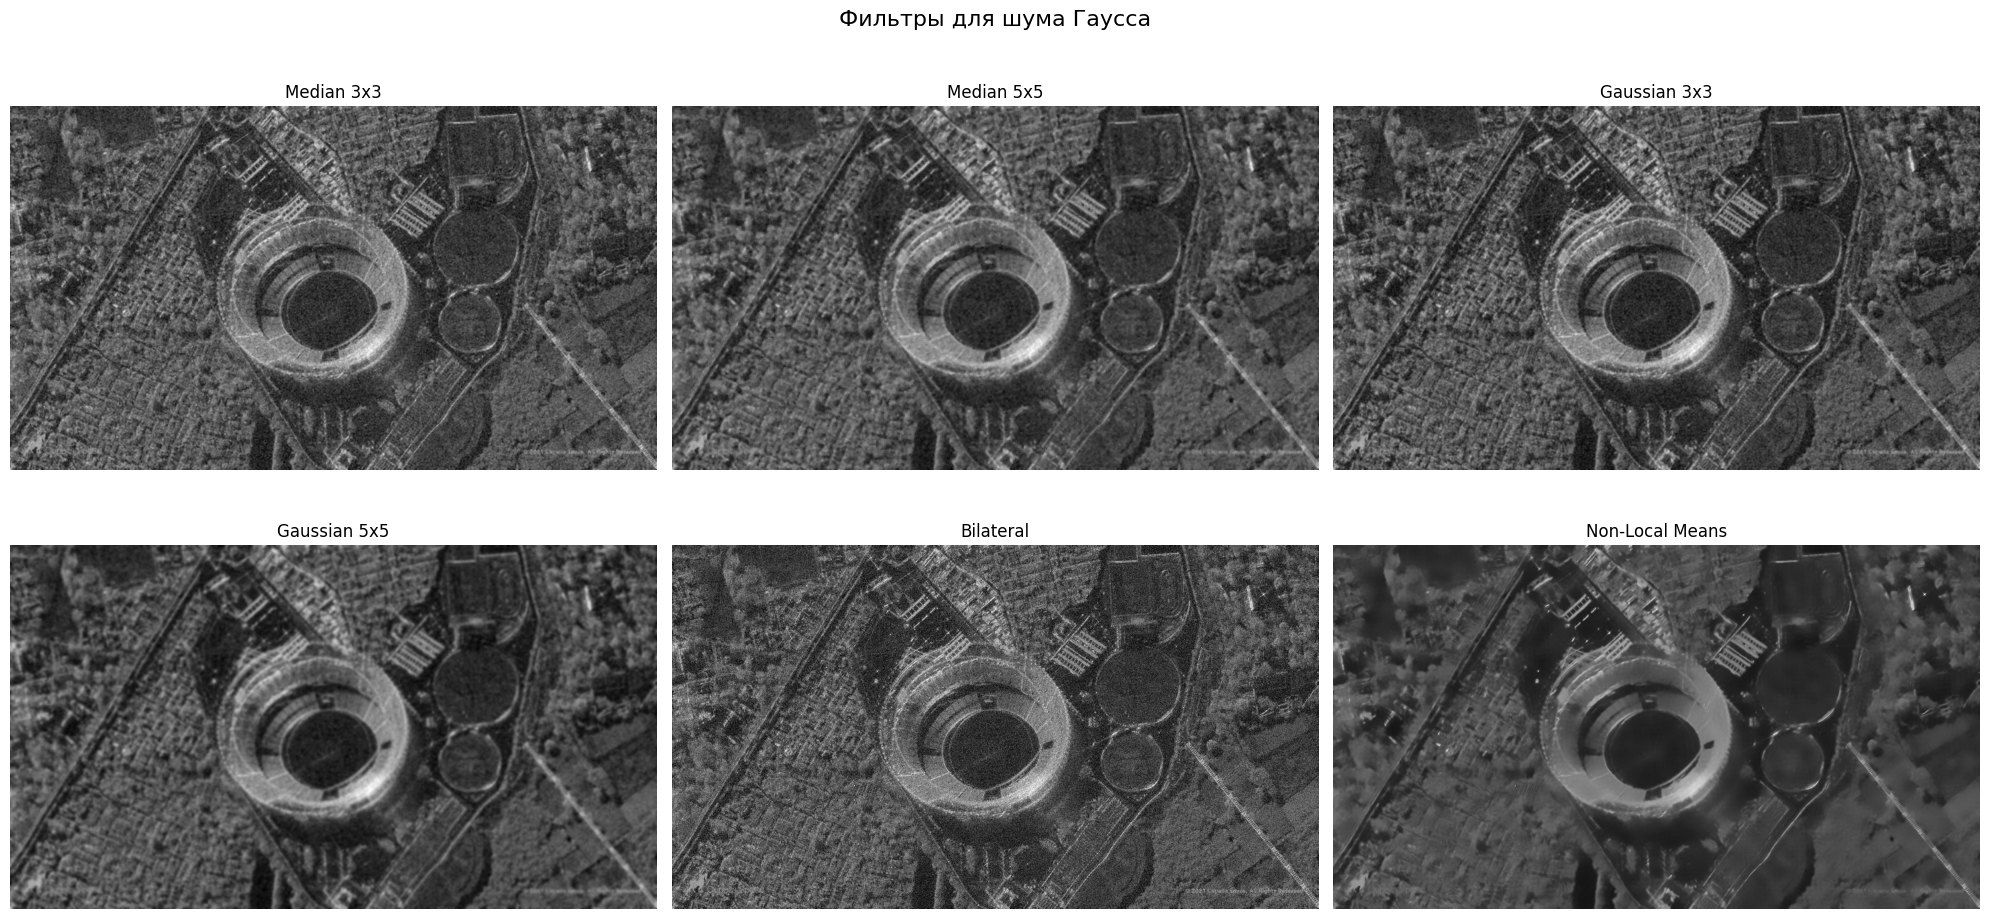

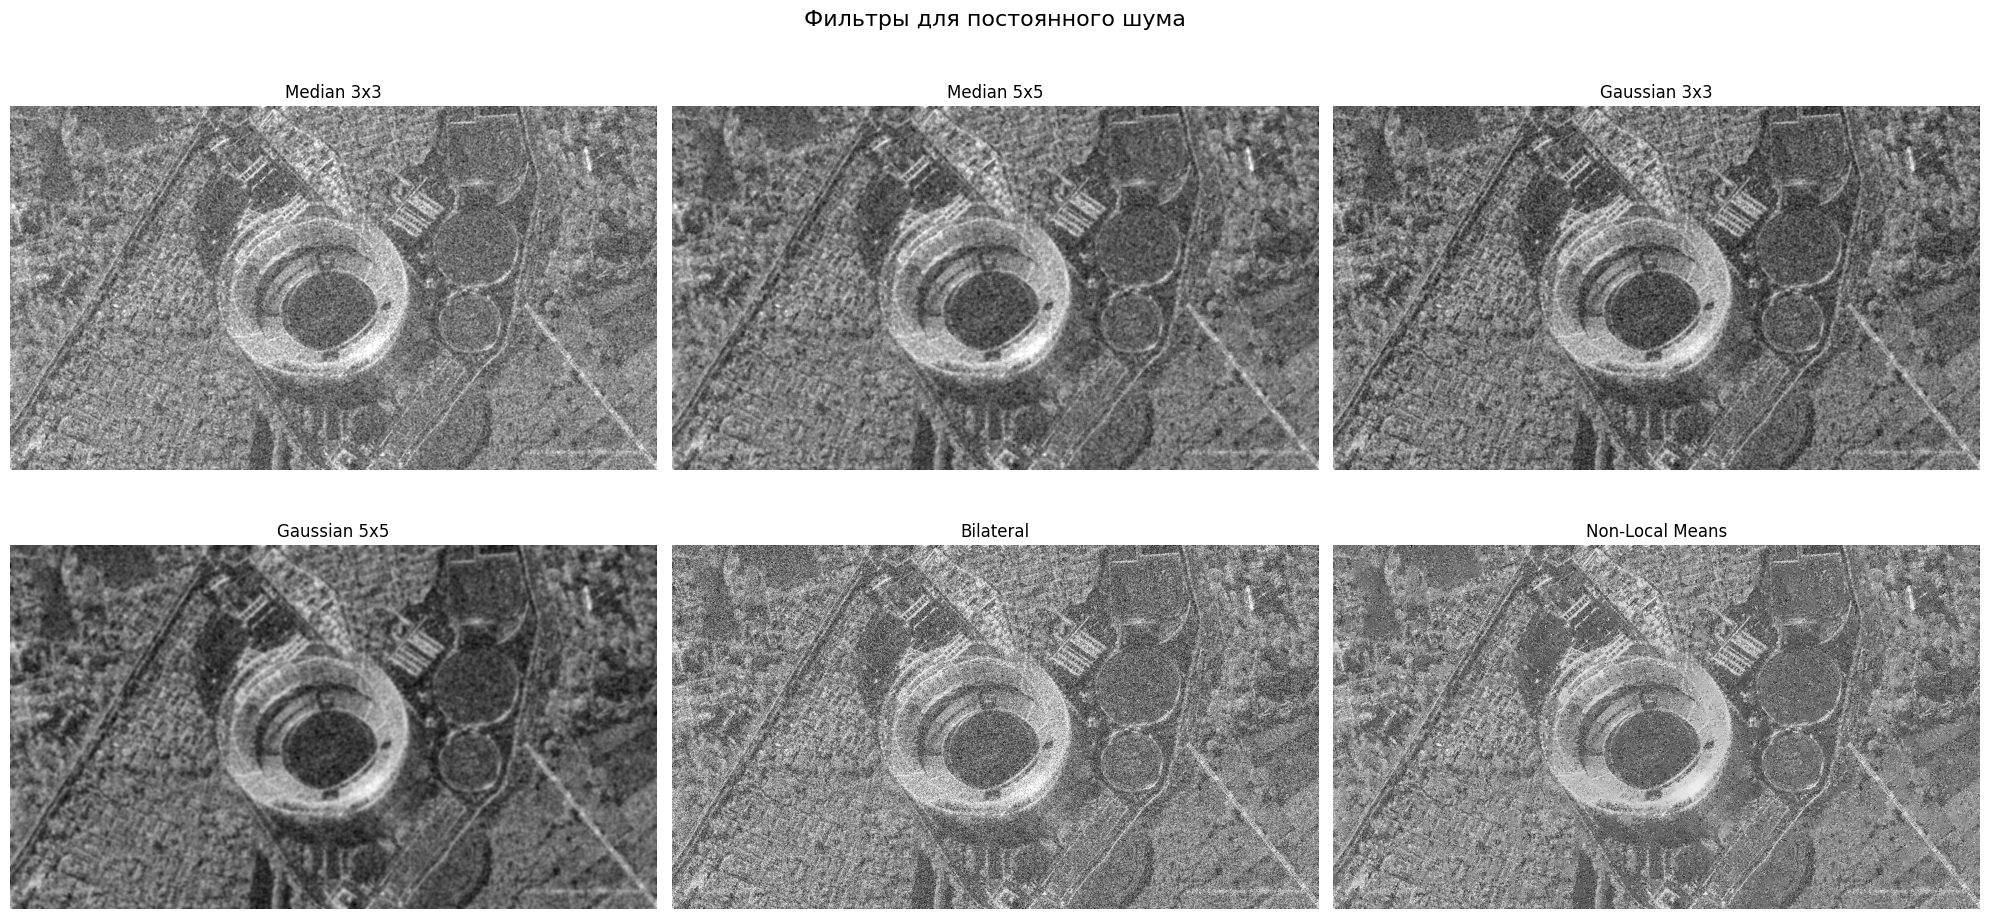

Лучший фильтр для шума Гаусса: Gaussian 3x3 (SSIM=0.7103)
Лучший фильтр для постоянного шума: Gaussian 3x3 (SSIM=0.4582)


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io, color, util, filters, restoration
from skimage.metrics import mean_squared_error, structural_similarity

img_path = "sar_1.jpg" 
img_color = io.imread(img_path) 
img_gray = color.rgb2gray(img_color) 
img_gray = util.img_as_float(img_gray)

plt.figure(figsize=(8, 6))
plt.imshow(img_gray, cmap='gray')
plt.title("Исходное изображение")
plt.axis('off')
plt.show()

# ------------------- Добавление шумов -------------------
def add_gaussian_noise(image, mean=0, sigma=0.1):
    return util.random_noise(image, mode='gaussian', mean=mean, var=sigma**2)

def add_constant_noise(image, a=0.43, b=0.0):
    mid = (a + b) / 2
    stdev = a - mid
    noise = np.random.normal(mid, stdev, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)

img_gn = add_gaussian_noise(img_gray)
img_constant = add_constant_noise(img_gray)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_gray, cmap='gray')
plt.title("Оригинал")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(img_gn, cmap='gray')
plt.title("Шум Гаусса")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(img_constant, cmap='gray')
plt.title("Постоянный шум")
plt.axis('off')
plt.show()

# ------------------- Фильтры -------------------
def apply_filters(image):
    return {
        "Median 3x3": filters.median(image, footprint=np.ones((3,3))),
        "Median 5x5": filters.median(image, footprint=np.ones((5,5))),
        "Gaussian 3x3": filters.gaussian(image, sigma=1),
        "Gaussian 5x5": filters.gaussian(image, sigma=2),
        "Bilateral": restoration.denoise_bilateral(image, sigma_color=0.05, sigma_spatial=3),
        "Non-Local Means": restoration.denoise_nl_means(image, h=0.1)
    }

filters_gn = apply_filters(img_gn)
filters_const = apply_filters(img_constant)

# ------------------- Метрики -------------------
def calculate_metrics(original, filtered):
    mse = mean_squared_error(original, filtered)
    ssim_val = structural_similarity(original, filtered, data_range=1.0)
    return mse, ssim_val

results = []
for name, filtered in filters_gn.items():
    mse, ssim_val = calculate_metrics(img_gray, filtered)
    results.append({"Filter": name, "Noise": "Gaussian", "MSE": mse, "SSIM": ssim_val})

for name, filtered in filters_const.items():
    mse, ssim_val = calculate_metrics(img_gray, filtered)
    results.append({"Filter": name, "Noise": "Constant", "MSE": mse, "SSIM": ssim_val})

df_metrics = pd.DataFrame(results)
print("Метрики фильтров:")
print(df_metrics)

# ------------------- Визуализация результатов -------------------
def plot_filtered_results(filters_dict, title):
    plt.figure(figsize=(20, 10))
    plt.suptitle(title, fontsize=16)
    for i, (name, img) in enumerate(filters_dict.items()):
        plt.subplot(2, 3, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_filtered_results(filters_gn, "Фильтры для шума Гаусса")
plot_filtered_results(filters_const, "Фильтры для постоянного шума")

# ------------------- Лучший фильтр -------------------
best_gn_filter = df_metrics[df_metrics["Noise"]=="Gaussian"].sort_values("SSIM", ascending=False).iloc[0]
best_const_filter = df_metrics[df_metrics["Noise"]=="Constant"].sort_values("SSIM", ascending=False).iloc[0]

print(f"Лучший фильтр для шума Гаусса: {best_gn_filter['Filter']} (SSIM={best_gn_filter['SSIM']:.4f})")
print(f"Лучший фильтр для постоянного шума: {best_const_filter['Filter']} (SSIM={best_const_filter['SSIM']:.4f})")
